In [8]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from jupyterplot import ProgressPlot

from nn_sim.data import DataLoader, DatasetNN
from nn_sim.net import layers as nn_layers
from nn_sim.net.layers import (
    Module, Sigmoid, ReLU, IdentityActivation, 
    Step, Softmax, SSELoss, MSELoss, MAELoss, BinaryCrossEntropyLoss,
    CategoricalCrossEntropyLoss, HiddenLayer)
from nn_sim.net.feedfoward import FeedFowardNeuralNetwork
from nn_sim.net.metrics import compute_classification_metrics, confusion_matrix

In [2]:
dataset = DatasetNN("./../datasets/iris.nnset")
print(dataset)

DatasetNN (IRIS flower dataset: Input Shape((150, 4)); Output Shape(150, 3))


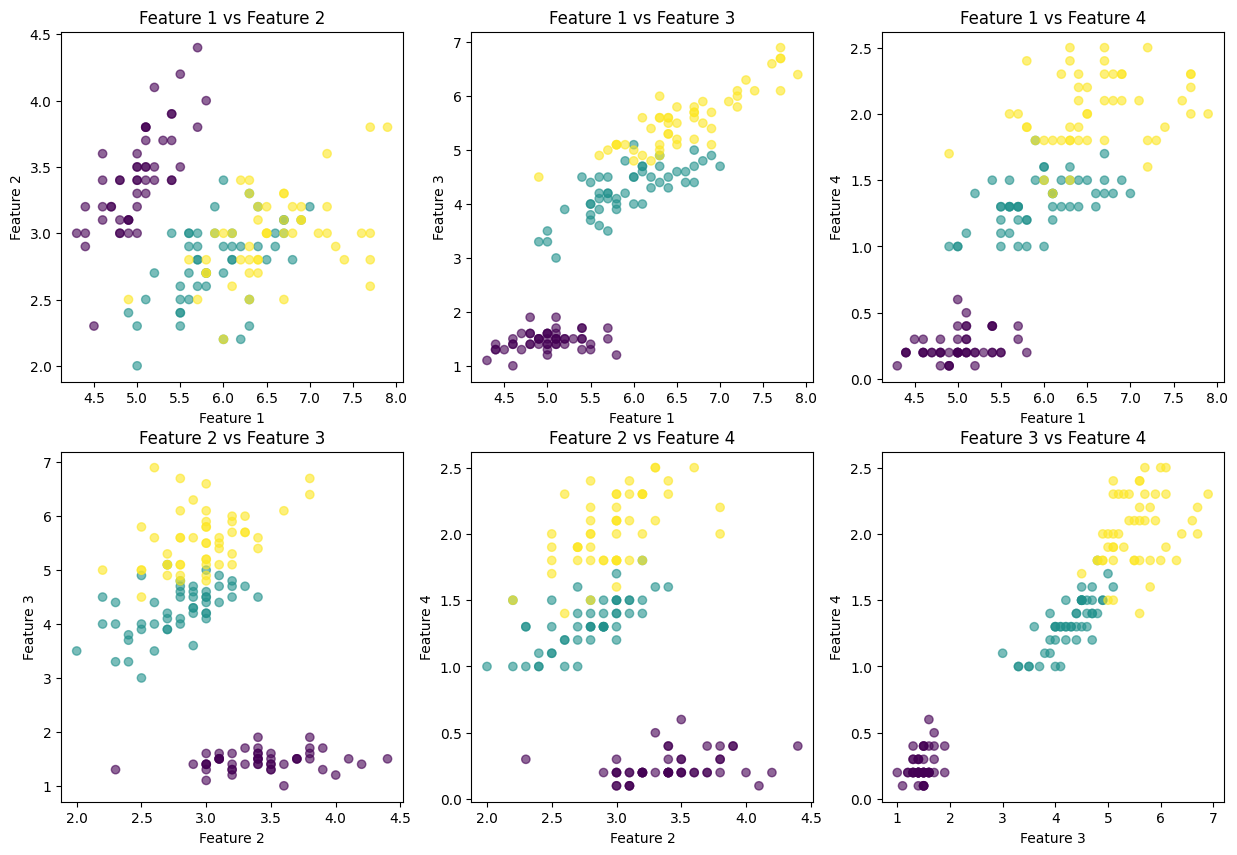

In [3]:
class_colors = np.argmax(dataset.Y, axis=1)

# Generate all combinations of feature pairs
feature_combinations = [(i, j) for i in range(4) for j in range(i + 1, 4)]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust subplot layout size as needed
axes = axes.flatten()

for ax, (i, j) in zip(axes, feature_combinations):
    scatter = ax.scatter(dataset.X[:, i], dataset.X[:, j], c=class_colors, cmap='viridis', alpha=0.6)
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel(f'Feature {j+1}')
    ax.set_title(f'Feature {i+1} vs Feature {j+1}')

plt.show()

## SGD

100%|██████████| 100000/100000 [00:51<00:00, 1948.20it/s]


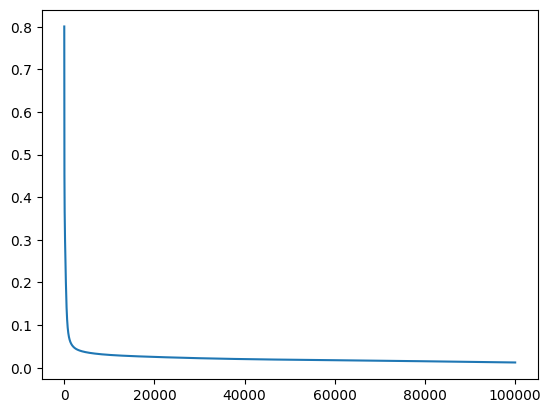

{'accuracy': 0.7777777777777778,
 'precision': 0.6666666666666666,
 'recall': 0.6666666666666666,
 'f1_score': 0.6666666666666666}

In [4]:
net = FeedFowardNeuralNetwork(
    4, 
    [
        (32, True, Sigmoid()),
        (10, True, Sigmoid()),
        (3, True, Sigmoid()),
    ]
)

loss_func = BinaryCrossEntropyLoss()
learning_rate = 0.1
MAX_EPOCHS = 100000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    net.zero_gradients()
    y_pred = net(dataset.X)
    loss = loss_func(y_pred, dataset.Y)
    losses.append(loss)
    net.backward(y_pred, dataset.Y, loss_func)
    
    for layer in net.layers:
        layer.weights = layer.weights - learning_rate * layer.grad_weights
        layer.bias = layer.bias - learning_rate * layer.grad_bias

plt.plot(losses)
plt.show()

y_pred = net(dataset.X)
compute_classification_metrics(dataset.Y, y_pred > 0.5)

## ADAM

100%|██████████| 10000/10000 [00:06<00:00, 1514.43it/s]


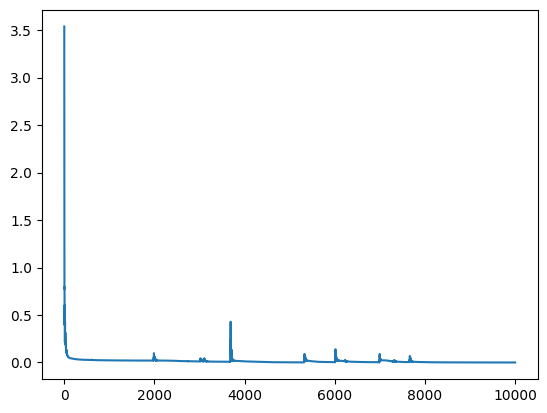

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]])

In [13]:
net = FeedFowardNeuralNetwork(
    4, 
    [
        (132, False, Sigmoid()),
        (3, False, Sigmoid()),
    ]
)

for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)


beta1 = 0.95
beta2 = 0.999
epsilon = 1e-7


loss_func = BinaryCrossEntropyLoss()
learning_rate = 0.1
MAX_EPOCHS = 10000

losses = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    net.zero_gradients()
    y_pred = net(dataset.X)
    loss = loss_func(y_pred, dataset.Y)
    losses.append(loss)
    net.backward(y_pred, dataset.Y, loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        # Update first moment estimate
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        # layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        # Update second moment estimate
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        # layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        # Compute bias-corrected first and second moment estimates
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        # Update parameters
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)

plt.plot(losses)
plt.show()

y_pred = net(dataset.X)
compute_classification_metrics(dataset.Y, y_pred > 0.5)
confusion_matrix(dataset.Y, y_pred, threshold=0.5)

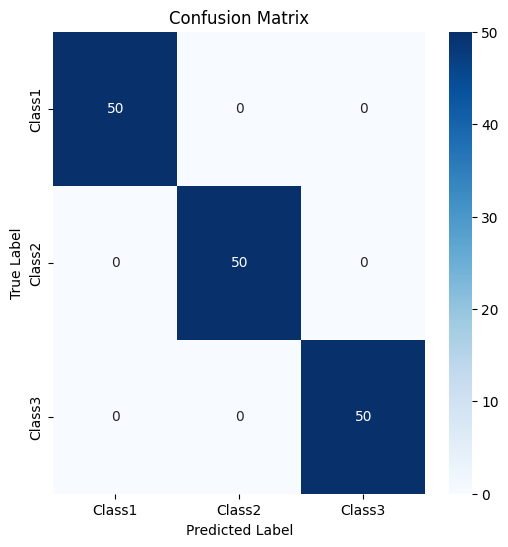

In [19]:
class_names = ['Class1', 'Class2', 'Class3']  # Example class names

conf_matrix = confusion_matrix(dataset.Y, y_pred, threshold=0.5)

plt.figure(figsize=(6, 6))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')  # Title of the heatmap
plt.ylabel('True Label')  # Y-axis label
plt.xlabel('Predicted Label')  # X-axis label
plt.show()